# Import

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

# Load Cifar10 data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, sep="\n")

170498071/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [3]:
x_train = tf.cast(x_train, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)

print(tf.reduce_max(x_train).numpy(), tf.reduce_min(x_train).numpy(), sep="\n")

255.0
0.0


In [4]:
x_train[0].shape

TensorShape([32, 32, 3])

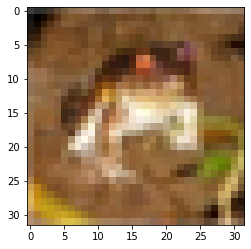

In [5]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(x_train[0], data_format="channels_last"))

In [6]:
def diffusion_schedule(step: int, max_step: int):
    if step > max_step:
        raise ValueError("`step` arg can't value more than `max_step`")
    return 1/(max_step - step + 1)

In [7]:
def cifar10_gaussian_forward_diffusion(x: tf.Tensor, step: int, max_step: int) -> tf.Tensor:
    """_summary_

    Args:
        x (tf.Tensor): Image tensor of shape (1, H, W, C) or (H, W, C)
        step (int): current forward step.
        max_step (int): final forward step.

    Returns:
        sample (tf.Tensor): noised image
    """
    shape = tf.TensorShape(tf.shape(x)).as_list()
    if len(shape) == 4:
        x = tf.squeeze(x)
    x = tf.reshape(x, (shape[0] * shape[1] * shape[2],))

    var_coef = tf.cast(diffusion_schedule(step, max_step), dtype=tf.float32)
    mean_coef = tf.math.sqrt(1. - var_coef)

    cov_diag = tf.ones(x.shape)
    nd = tfd.MultivariateNormalDiag(loc=mean_coef * x, scale_diag=var_coef * cov_diag)

    sample = tf.reshape(nd.sample(), shape)
    return sample

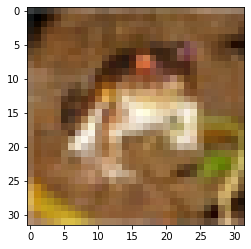

In [8]:
MAX_STEP = 10000

x = cifar10_gaussian_forward_diffusion(x=x_train[0], step=1, max_step=MAX_STEP)
img = tf.keras.preprocessing.image.array_to_img(x, data_format="channels_last")

plt.imshow(img)

  0%|          | 0/9997 [00:00<?, ?it/s]

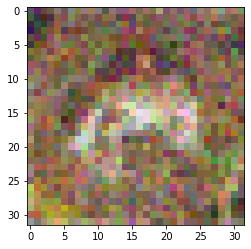

In [9]:
for i in tqdm(range(2, MAX_STEP-1)):
  x = cifar10_gaussian_forward_diffusion(x=x, step=i, max_step=MAX_STEP)

image = tf.keras.preprocessing.image.array_to_img(x, data_format="channels_last")
plt.imshow(image)